In [29]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import pytz
from numba import njit

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import base_optimizer

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import order_nb, sort_call_seq_nb
from vectorbt.portfolio.enums import SizeType, Direction

In [30]:
# Define params
symbols = ['META', 'AMZN', 'NFLX', 'GOOG', 'AAPL']
start_date = datetime(2017, 1, 1, tzinfo=pytz.utc)
end_date = datetime(2020, 1, 1, tzinfo=pytz.utc)
num_tests = 2000

vbt.settings.array_wrapper['freq'] = 'days'
vbt.settings.returns['year_freq'] = '252 days'
vbt.settings.portfolio['seed'] = 42
vbt.settings.portfolio.stats['incl_unrealized'] = True

In [31]:
yfdata = vbt.YFData.download(symbols, start=start_date, end=end_date)

print(yfdata.symbols)

['META', 'AMZN', 'NFLX', 'GOOG', 'AAPL']


In [32]:
ohlcv = yfdata.concat()

print(ohlcv.keys())

dict_keys(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])


In [33]:
price = ohlcv['Close']

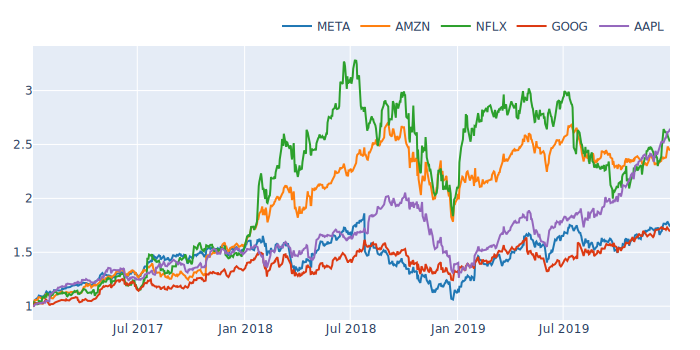

In [6]:
# Plot normalized price series
(price / price.iloc[0]).vbt.plot().show_svg()

In [7]:
returns = price.pct_change()

In [8]:
print(returns.mean())

symbol
META    0.000918
AMZN    0.001341
NFLX    0.001509
GOOG    0.000812
AAPL    0.001414
dtype: float64


In [9]:
print(returns.std())

symbol
META    0.018262
AMZN    0.017309
NFLX    0.023354
GOOG    0.014594
AAPL    0.015544
dtype: float64


In [10]:
print(returns.corr())

symbol      META      AMZN      NFLX      GOOG      AAPL
symbol                                                  
META    1.000000  0.595549  0.464163  0.612674  0.467665
AMZN    0.595549  1.000000  0.614445  0.687693  0.601881
NFLX    0.464163  0.614445  1.000000  0.554071  0.453648
GOOG    0.612674  0.687693  0.554071  1.000000  0.605521
AAPL    0.467665  0.601881  0.453648  0.605521  1.000000


## vectorbt: Random search

### One-time allocation

In [41]:
np.random.seed(42)

# Generate random weights, n times
weights = []
for i in range(num_tests):
    w = np.random.random_sample(len(symbols))
    w = w / np.sum(w)
    weights.append(w)

print(len(weights))

2000


In [42]:
# Build column hierarchy such that one weight corresponds to one price series
_price = price.vbt.tile(num_tests, keys=pd.Index(np.arange(num_tests), name='symbol_group'))
_price = _price.vbt.stack_index(pd.Index(np.concatenate(weights), name='weights'))

print(_price.columns)

MultiIndex([( 0.13319702814025883,    0, 'META'),
            ( 0.33810081711389406,    0, 'AMZN'),
            ( 0.26031768763785473,    0, 'NFLX'),
            (  0.2128998389048247,    0, 'GOOG'),
            ( 0.05548462820316767,    0, 'AAPL'),
            ( 0.06528491964469331,    1, 'META'),
            ( 0.02430844330237927,    1, 'AMZN'),
            (  0.3625014516740258,    1, 'NFLX'),
            (  0.2515713061862386,    1, 'GOOG'),
            ( 0.29633387919266296,    1, 'AAPL'),
            ...
            (  0.2056564359049325, 1998, 'META'),
            ( 0.14846396871443943, 1998, 'AMZN'),
            ( 0.21512097636364197, 1998, 'NFLX'),
            (  0.3738566007394396, 1998, 'GOOG'),
            (0.056902018277546554, 1998, 'AAPL'),
            ( 0.25860265182212094, 1999, 'META'),
            (  0.2706191852849979, 1999, 'AMZN'),
            (  0.2854538191129893, 1999, 'NFLX'),
            ( 0.11985160754099378, 1999, 'GOOG'),
            (  0.0654727362388982,

In [43]:
# Define order size
size = np.full_like(_price, np.nan)
size[0, :] = np.concatenate(weights)  # allocate at first timestamp, do nothing afterwards

print(size.shape)

(754, 10000)


In [44]:
# Run simulation
pf = vbt.Portfolio.from_orders(
    close=_price,
    size=size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True
) # all weights sum to 1, no shorting, and 100% investment in risky assets

print(len(pf.orders))

10000


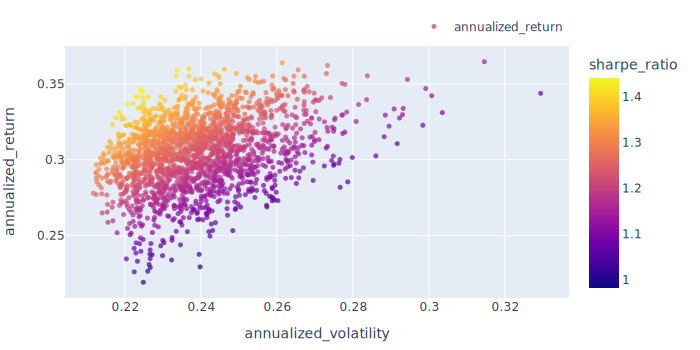

In [45]:
# Plot annualized return against volatility, color by sharpe ratio
annualized_return = pf.annualized_return()
annualized_return.index = pf.annualized_volatility()
annualized_return.vbt.scatterplot(
    trace_kwargs=dict(
        mode='markers', 
        marker=dict(
            color=pf.sharpe_ratio(),
            colorbar=dict(
                title='sharpe_ratio'
            ),
            size=5,
            opacity=0.7
        )
    ),
    xaxis_title='annualized_volatility',
    yaxis_title='annualized_return'
).show_svg()

In [46]:
# Get index of the best group according to the target metric
best_symbol_group = pf.sharpe_ratio().idxmax()

print(best_symbol_group)

214


In [47]:
# Print best weights
print(weights[best_symbol_group])

[0.18782144 0.14807743 0.0266817  0.01132979 0.62608964]


In [48]:
# Compute default stats
print(pf.iloc[best_symbol_group].stats())

Start                         2017-01-03 05:00:00+00:00
End                           2019-12-31 05:00:00+00:00
Period                                754 days 00:00:00
Start Value                                       100.0
End Value                                    243.693285
Total Return [%]                             143.693285
Benchmark Return [%]                         121.870064
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              33.993892
Max Drawdown Duration                 277 days 00:00:00
Total Trades                                          5
Total Closed Trades                                   0
Total Open Trades                                     5
Open Trade PnL                               143.693285
Win Rate [%]                                        NaN
Best Trade [%]                                      NaN
Worst Trade [%]                                 

### Rebalance monthly

In [49]:
# Select the first index of each month
rb_mask = ~_price.index.to_period('M').duplicated()

print(rb_mask.sum())

36


/var/folders/k5/938fszt94ygcn886stp4kkjh0000gn/T/ipykernel_33589/2291127415.py:2: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/var/folders/k5/938fszt94ygcn886stp4kkjh0000gn/T/ipykernel_33589/2291127415.py:2: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'M' instead.



In [50]:
rb_size = np.full_like(_price, np.nan)
rb_size[rb_mask, :] = np.concatenate(weights)  # allocate at mask

print(rb_size.shape)

(754, 10000)


In [51]:
# Run simulation, with rebalancing monthly
rb_pf = vbt.Portfolio.from_orders(
    close=_price,
    size=rb_size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    call_seq='auto'  # important: sell before buy
)

print(len(rb_pf.orders))

359997


In [52]:
rb_best_symbol_group = rb_pf.sharpe_ratio().idxmax()

print(rb_best_symbol_group)

979


In [53]:
print(weights[rb_best_symbol_group])

[0.05279463 0.09641785 0.19522758 0.05880828 0.59675165]


In [54]:
print(rb_pf.iloc[rb_best_symbol_group].stats())

Start                           2017-01-03 05:00:00+00:00
End                             2019-12-31 05:00:00+00:00
Period                                  754 days 00:00:00
Start Value                                         100.0
End Value                                      259.826583
Total Return [%]                               159.826583
Benchmark Return [%]                           121.870064
Max Gross Exposure [%]                              100.0
Total Fees Paid                                       0.0
Max Drawdown [%]                                34.301973
Max Drawdown Duration                   266 days 00:00:00
Total Trades                                           90
Total Closed Trades                                    85
Total Open Trades                                       5
Open Trade PnL                                 117.124449
Win Rate [%]                                    97.647059
Best Trade [%]                                 192.175674
Worst Trade [%

In [26]:
def plot_allocation(rb_pf):
    # Plot weights development of the portfolio
    rb_asset_value = rb_pf.asset_value(group_by=False)
    rb_value = rb_pf.value()
    rb_idxs = np.flatnonzero((rb_pf.asset_flow() != 0).any(axis=1))
    rb_dates = rb_pf.wrapper.index[rb_idxs]
    fig = (rb_asset_value.vbt / rb_value).vbt.plot(
        trace_names=symbols,
        trace_kwargs=dict(
            stackgroup='one'
        )
    )
    for rb_date in rb_dates:
        fig.add_shape(
            dict(
                xref='x',
                yref='paper',
                x0=rb_date,
                x1=rb_date,
                y0=0,
                y1=1,
                line_color=fig.layout.template.layout.plot_bgcolor
            )
        )
    fig.show_svg()

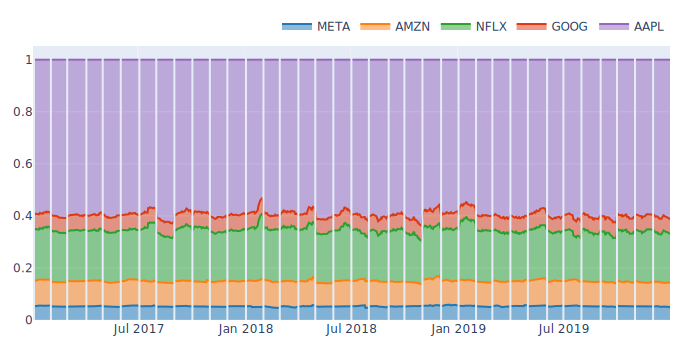

In [56]:
plot_allocation(rb_pf.iloc[rb_best_symbol_group])  # best group

### Search and rebalance every 30 days

Utilize low-level API to dynamically search for best Sharpe ratio and rebalance accordingly. Compared to previous method, we won't utilize stacking, but do search in a loop instead. We also will use days instead of months, as latter may contain a various number of trading days.

In [17]:
srb_sharpe = np.full(price.shape[0], np.nan)

@njit
def pre_sim_func_nb(c, every_nth):
    # Define rebalancing days
    c.segment_mask[:, :] = False
    c.segment_mask[every_nth::every_nth, :] = True
    return ()

@njit
def find_weights_nb(c, price, num_tests):
    # Find optimal weights based on best Sharpe ratio
    returns = (price[1:] - price[:-1]) / price[:-1]
    returns = returns[1:, :]  # cannot compute np.cov with NaN
    mean = nanmean_nb(returns)
    cov = np.cov(returns, rowvar=False)  # masked arrays not supported by Numba (yet)
    best_sharpe_ratio = -np.inf
    weights = np.full(c.group_len, np.nan, dtype=np.float_)
    
    for i in range(num_tests):
        # Generate weights
        w = np.random.random_sample(c.group_len)
        w = w / np.sum(w)
        
        # Compute annualized mean, covariance, and Sharpe ratio
        p_return = np.sum(mean * w) * ann_factor
        p_std = np.sqrt(np.dot(w.T, np.dot(cov, w))) * np.sqrt(ann_factor)
        sharpe_ratio = p_return / p_std
        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            weights = w
            
    return best_sharpe_ratio, weights

@njit
def pre_segment_func_nb(c, find_weights_nb, history_len, ann_factor, num_tests, srb_sharpe):
    if history_len == -1:
        # Look back at the entire time period
        close = c.close[:c.i, c.from_col:c.to_col]
    else:
        # Look back at a fixed time period
        if c.i - history_len <= 0:
            return (np.full(c.group_len, np.nan),)  # insufficient data
        close = c.close[c.i - history_len:c.i, c.from_col:c.to_col]

    # Find optimal weights
    best_sharpe_ratio, weights = find_weights_nb(c, close, num_tests)
    srb_sharpe[c.i] = best_sharpe_ratio

    # Update valuation price and reorder orders
    size_type = SizeType.TargetPercent
    direction = Direction.LongOnly
    order_value_out = np.empty(c.group_len, dtype=np.float_)
    for k in range(c.group_len):
        col = c.from_col + k
        c.last_val_price[col] = c.close[c.i, col]
    sort_call_seq_nb(c, weights, size_type, direction, order_value_out)

    return (weights,)

@njit
def order_func_nb(c, weights):
    col_i = c.call_seq_now[c.call_idx]
    return order_nb(
        weights[col_i], 
        c.close[c.i, c.col],
        size_type=SizeType.TargetPercent
    )

In [18]:
ann_factor = returns.vbt.returns.ann_factor

In [19]:
# Run simulation using a custom order function
srb_pf = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    pre_sim_func_nb=pre_sim_func_nb,
    pre_sim_args=(30,),
    pre_segment_func_nb=pre_segment_func_nb,
    pre_segment_args=(find_weights_nb, -1, ann_factor, num_tests, srb_sharpe),
    cash_sharing=True, 
    group_by=True
)

In [76]:
# import numpy as np
# from numba import njit

# # Initialize the attractiveness_scores array
# attractiveness_scores = np.full(price.shape[0], np.nan)

# @njit
# def calculate_std(price):
#     returns = (price[1:] - price[:-1]) / price[:-1]
#     std_dev = np.std(returns, axis=0)
#     return std_dev

# @njit
# def pre_sim_func_nb(c, every_nth):
#     # Define rebalancing days
#     c.segment_mask[:, :] = False
#     c.segment_mask[every_nth::every_nth, :] = True
#     return ()

# @njit
# def find_weights_nb(c, price):
#     # Calculate standard deviation of returns
#     std_dev = calculate_std(price)
    
#     # Calculate "attractiveness" score (inverse of standard deviation)
#     attractiveness = 1 / std_dev
    
#     # Normalize attractiveness scores to get weights
#     weights = attractiveness / np.sum(attractiveness)
    
#     return attractiveness, weights

# @njit
# def pre_segment_func_nb(c, find_weights_nb, history_len, attractiveness_scores):
#     if history_len == -1:
#         # Look back at the entire time period
#         close = c.close[:c.i, c.from_col:c.to_col]
#     else:
#         # Look back at a fixed time period
#         if c.i - history_len <= 0:
#             return (np.full(c.group_len, np.nan),)  # insufficient data
#         close = c.close[c.i - history_len:c.i, c.from_col:c.to_col]

#     # Find optimal weights based on attractiveness score
#     attractiveness, weights = find_weights_nb(c, close)
#     attractiveness_scores[c.i] = np.mean(attractiveness)  # Store the mean attractiveness score

#     # Update valuation price and reorder orders
#     size_type = SizeType.TargetPercent
#     direction = Direction.LongOnly
#     order_value_out = np.empty(c.group_len, dtype=np.float_)
#     for k in range(c.group_len):
#         col = c.from_col + k
#         c.last_val_price[col] = c.close[c.i, col]
#     sort_call_seq_nb(c, weights, size_type, direction, order_value_out)

#     return (weights,)

# @njit
# def order_func_nb(c, weights):
#     col_i = c.call_seq_now[c.call_idx]
#     return order_nb(
#         weights[col_i], 
#         c.close[c.i, c.col],
#         size_type=SizeType.TargetPercent
#     )

In [77]:
# Run simulation using a custom order function
# srb_pf = vbt.Portfolio.from_order_func(
#     price,
#     order_func_nb,
#     pre_sim_func_nb=pre_sim_func_nb,
#     pre_sim_args=(30,),
#     pre_segment_func_nb=pre_segment_func_nb,
#     pre_segment_args=(find_weights_nb, -1, attractiveness_scores),
#     cash_sharing=True, 
#     group_by=True
# )

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<function sum at 0x110f99ee0>) found for signature:
 
 >>> sum(float64)
 
There are 2 candidate implementations:
[1m  - Of which 2 did not match due to:
  Overload of function 'sum': File: numba/core/typing/npydecl.py: Line 373.
    With argument(s): '(float64)':[0m
[1m   No match.[0m
[0m
[0m[1mDuring: resolving callee type: Function(<function sum at 0x110f99ee0>)[0m
[0m[1mDuring: typing of call at /var/folders/k5/938fszt94ygcn886stp4kkjh0000gn/T/ipykernel_33589/2546232841.py (29)
[0m
[1m
File "../../../../../../var/folders/k5/938fszt94ygcn886stp4kkjh0000gn/T/ipykernel_33589/2546232841.py", line 29:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function find_weights_nb at 0x32d82c400>))[0m
[0m[1mDuring: typing of call at /var/folders/k5/938fszt94ygcn886stp4kkjh0000gn/T/ipykernel_33589/2546232841.py (45)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function find_weights_nb at 0x32d82c400>))[0m
[0m[1mDuring: typing of call at /var/folders/k5/938fszt94ygcn886stp4kkjh0000gn/T/ipykernel_33589/2546232841.py (45)
[0m
[1m
File "../../../../../../var/folders/k5/938fszt94ygcn886stp4kkjh0000gn/T/ipykernel_33589/2546232841.py", line 45:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function pre_segment_func_nb at 0x32c773240>))[0m
[0m[1mDuring: typing of call at /opt/homebrew/anaconda3/lib/python3.11/site-packages/vectorbt/portfolio/nb.py (2920)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function pre_segment_func_nb at 0x32c773240>))[0m
[0m[1mDuring: typing of call at /opt/homebrew/anaconda3/lib/python3.11/site-packages/vectorbt/portfolio/nb.py (2920)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function pre_segment_func_nb at 0x32c773240>))[0m
[0m[1mDuring: typing of call at /opt/homebrew/anaconda3/lib/python3.11/site-packages/vectorbt/portfolio/nb.py (2920)
[0m
[1m
File "../../../../../../opt/homebrew/anaconda3/lib/python3.11/site-packages/vectorbt/portfolio/nb.py", line 2920:[0m
[1m        ... def post_sim_func_nb(c):
            <source elided>
                )
[1m                pre_segment_out = pre_segment_func_nb(pre_seg_ctx, *pre_group_out, *pre_segment_args)
[0m                [1m^[0m[0m


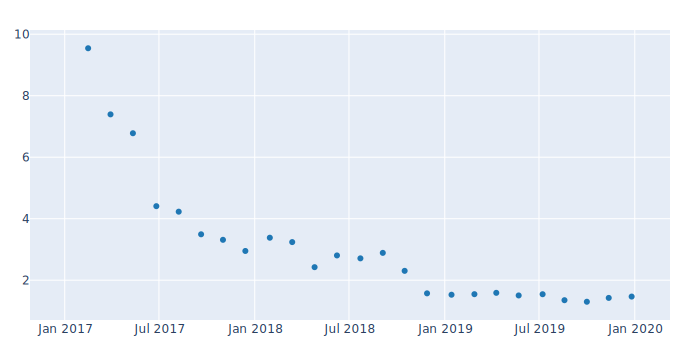

In [30]:
# Plot best Sharpe ratio at each rebalancing day
pd.Series(srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [31]:
print(srb_pf.stats())

Start                           2017-01-03 00:00:00+00:00
End                             2019-12-31 00:00:00+00:00
Period                                  754 days 00:00:00
Start Value                                         100.0
End Value                                      182.103898
Total Return [%]                                82.103898
Benchmark Return [%]                           121.870057
Max Gross Exposure [%]                              100.0
Total Fees Paid                                       0.0
Max Drawdown [%]                                34.350877
Max Drawdown Duration                   310 days 00:00:00
Total Trades                                           67
Total Closed Trades                                    62
Total Open Trades                                       5
Open Trade PnL                                  33.965423
Win Rate [%]                                    77.419355
Best Trade [%]                                   43.78028
Worst Trade [%

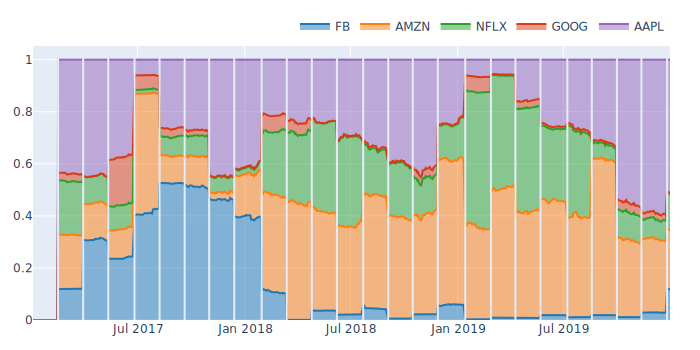

In [32]:
plot_allocation(srb_pf)

You can see how weights stabilize themselves with growing data.

In [33]:
# Run simulation, but now consider only the last 252 days of data
srb252_sharpe = np.full(price.shape[0], np.nan)

srb252_pf = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    pre_sim_func_nb=pre_sim_func_nb,
    pre_sim_args=(30,),
    pre_segment_func_nb=pre_segment_func_nb,
    pre_segment_args=(find_weights_nb, 252, ann_factor, num_tests, srb252_sharpe),
    cash_sharing=True, 
    group_by=True
)

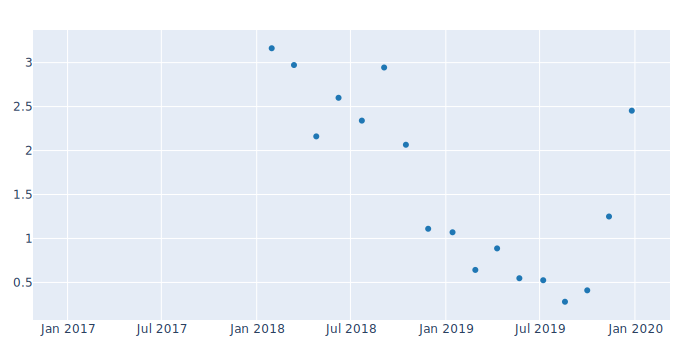

In [34]:
pd.Series(srb252_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [35]:
print(srb252_pf.stats())

Start                           2017-01-03 00:00:00+00:00
End                             2019-12-31 00:00:00+00:00
Period                                  754 days 00:00:00
Start Value                                         100.0
End Value                                      138.658042
Total Return [%]                                38.658042
Benchmark Return [%]                           121.870057
Max Gross Exposure [%]                              100.0
Total Fees Paid                                       0.0
Max Drawdown [%]                                33.135977
Max Drawdown Duration                   192 days 00:00:00
Total Trades                                           39
Total Closed Trades                                    34
Total Open Trades                                       5
Open Trade PnL                                  10.464979
Win Rate [%]                                    58.823529
Best Trade [%]                                  16.361723
Worst Trade [%

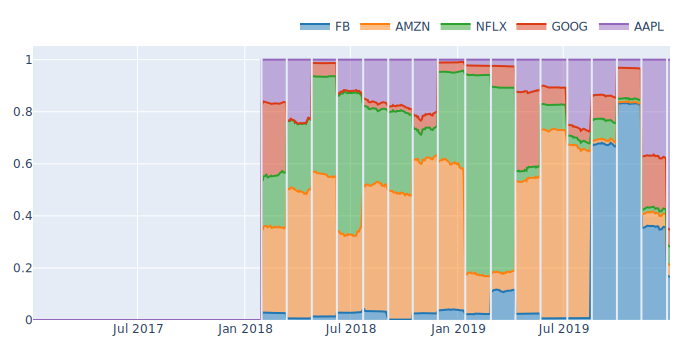

In [36]:
plot_allocation(srb252_pf)

A much more volatile weight distribution.

## PyPortfolioOpt + vectorbt

### One-time allocation

In [11]:
# Calculate expected returns and sample covariance amtrix
avg_returns = expected_returns.mean_historical_return(price)
cov_mat = risk_models.sample_cov(price)

# Get weights maximizing the Sharpe ratio
ef = EfficientFrontier(avg_returns, cov_mat)
weights = ef.max_sharpe()
clean_weights = ef.clean_weights()
pyopt_weights = np.array([clean_weights[symbol] for symbol in symbols])

print(pyopt_weights)

[0.      0.22232 0.06347 0.      0.7142 ]


In [12]:
pyopt_size = np.full_like(price, np.nan)
pyopt_size[0, :] = pyopt_weights  # allocate at first timestamp, do nothing afterwards

print(pyopt_size.shape)

(754, 5)


In [20]:
# Run simulation with weights from PyPortfolioOpt
pyopt_pf = vbt.Portfolio.from_orders(
    close=price,
    size=pyopt_size,
    size_type='targetpercent',
    group_by=True,
    cash_sharing=True
)

print(len(pyopt_pf.orders))

3


Faster than stacking solution, but doesn't let you compare weights.

In [14]:
print(pyopt_pf.stats())

Start                         2017-01-03 05:00:00+00:00
End                           2019-12-31 05:00:00+00:00
Period                                754 days 00:00:00
Start Value                                       100.0
End Value                                    259.637703
Total Return [%]                             159.637703
Benchmark Return [%]                         121.870055
Max Gross Exposure [%]                        99.999615
Total Fees Paid                                     0.0
Max Drawdown [%]                              35.254993
Max Drawdown Duration                 266 days 00:00:00
Total Trades                                          3
Total Closed Trades                                   0
Total Open Trades                                     3
Open Trade PnL                               159.637703
Win Rate [%]                                        NaN
Best Trade [%]                                      NaN
Worst Trade [%]                                 

### Search and rebalance monthly

You can't use third-party optimization packages within Numba (yet).

Here you have two choices:
1) Use `os.environ['NUMBA_DISABLE_JIT'] = '1'` before all imports to disable Numba completely
2) Disable Numba for the function, but also for every other function in the stack that calls it

We will demonstrate the second option.

In [41]:
from rebalancer.Portfolio import Portfolio
portfolio_2 = {
    "META": 0.0934,
    "AMZN": 0.0978,
    "NFLX": 0.0369,
    "GOOG": 0.0429,
    "AAPL": 0.154077980787342,
}

my_portfolio = Portfolio(portfolio_2)

price = my_portfolio.prices
returns = price.pct_change()
ann_factor = returns.vbt.returns.ann_factor



[*********************100%%**********************]  5 of 5 completed


In [42]:
def pyopt_find_weights(sc, price, num_tests):  # no @njit decorator = it's a pure Python function
    # Calculate expected returns and sample covariance matrix
    price = pd.DataFrame(price, columns=symbols)
    avg_returns = expected_returns.mean_historical_return(price)
    cov_mat = risk_models.sample_cov(price)

    # Get weights maximizing the Sharpe ratio
    ef = EfficientFrontier(avg_returns, cov_mat)
    weights = ef.max_sharpe()
    clean_weights = ef.clean_weights()
    weights = np.array([clean_weights[symbol] for symbol in symbols])
    best_sharpe_ratio = base_optimizer.portfolio_performance(weights, avg_returns, cov_mat)[2]
            
    return best_sharpe_ratio, weights

In [43]:
pyopt_srb_sharpe = np.full(price.shape[0], np.nan)

# Run simulation with a custom order function
pyopt_srb_pf = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    pre_sim_func_nb=pre_sim_func_nb,
    pre_sim_args=(30,),
    pre_segment_func_nb=pre_segment_func_nb.py_func,  # run pre_segment_func_nb as pure Python function
    pre_segment_args=(pyopt_find_weights, -1, ann_factor, num_tests, pyopt_srb_sharpe),
    cash_sharing=True, 
    group_by=True,
    use_numba=False  # run simulate_nb as pure Python function
)

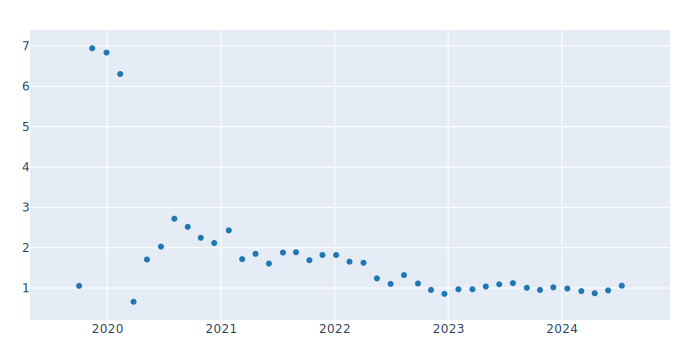

In [44]:
pd.Series(pyopt_srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [45]:
print(pyopt_srb_pf.stats())

Start                                 2019-08-21 00:00:00
End                                   2024-08-21 00:00:00
Period                                 1259 days 00:00:00
Start Value                                         100.0
End Value                                       340.09657
Total Return [%]                                240.09657
Benchmark Return [%]                           190.245132
Max Gross Exposure [%]                              100.0
Total Fees Paid                                       0.0
Max Drawdown [%]                                31.274119
Max Drawdown Duration                   365 days 00:00:00
Total Trades                                           30
Total Closed Trades                                    28
Total Open Trades                                       2
Open Trade PnL                                 121.238954
Win Rate [%]                                    82.142857
Best Trade [%]                                  60.420165
Worst Trade [%

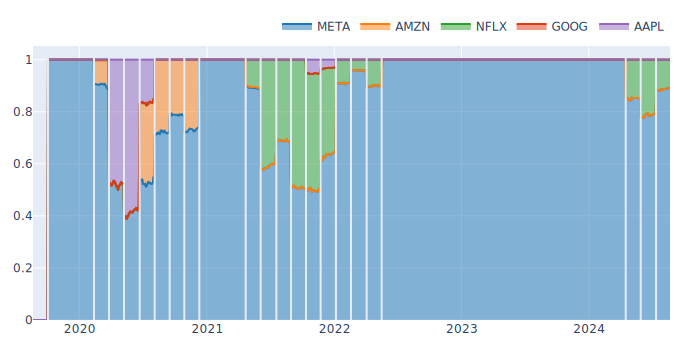

In [46]:
plot_allocation(pyopt_srb_pf)